In [52]:
%load_ext autoreload 
%autoreload 2
from lens_simulation import SimulationRunner


sim_runner = SimulationRunner.SimulationRunner("config.yaml")
sim_runner.initialise_simulation()
sim_runner.setup_simulation()
# sim_runner.run_simulations()

# Test github

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--------------------------------------------------

Simulation Run: subtly-tight-zebra (dfef4f0d-42a3-4fc5-a911-be611f9f78c4)
Data: \\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\subtly-tight-zebra
--------------------------------------------------

6 Lens Configurations. 3 Stage Configurations
Generating 18 Simulation Configurations


  0%|          | 0/6 [00:00<?, ?it/s]

{'lenses': [{'exponent': 0.0,
             'height': 7e-05,
             'medium': 'medium_1',
             'name': 'lens_1'},
            {'exponent': 2.0,
             'height': 7.5e-05,
             'medium': 'medium_1',
             'name': 'lens_2'}],
 'log_dir': '\\\\ad.monash.edu\\home\\User028\\pcle0002\\Documents\\repos\\lens_simulation\\src\\lens_simulation\\log\\subtly-tight-zebra',
 'mediums': [{'name': 'medium_1', 'refractive_index': 2.348},
             {'name': 'medium_2', 'refractive_index': 1.5}],
 'options': {'save': False, 'save_plot': True, 'verbose': False},
 'run_id': UUID('dfef4f0d-42a3-4fc5-a911-be611f9f78c4'),
 'run_petname': 'subtly-tight-zebra',
 'sim_parameters': {'A': 10000,
                    'pixel_size': 1e-06,
                    'sim_wavelength': 4.88e-07,
                    'sim_width': 0.0045},
 'stages': [{'finish_distance': 0.01,
             'lens': 'lens_1',
             'n_slices': 100,
             'options': {'focal_distance_multiple': 2.0,


## Simulation Class
Test example simulation



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


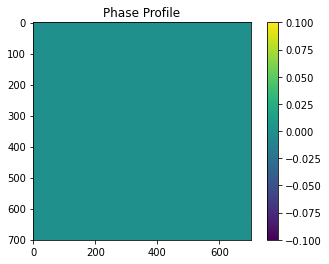

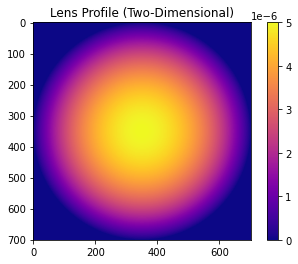

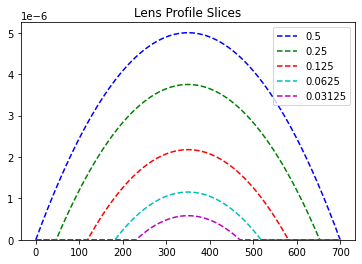

In [11]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from lens_simulation import Simulation
import uuid
import os
import yaml
import petname


def load_simulation_config(config_filename: str = "config.yaml") -> dict:
    with open(config_filename, "r") as f:
        conf = yaml.full_load(f)

    run_id = petname.generate(3)  # run_id is for when running a batch of sims, each sim has unique id
    data_path = os.path.join(conf["options"]["log_dir"],  str(run_id))
    config = {"run_id": run_id, 
                "parameters": None, 
                "log_dir": data_path, 
                "sim_parameters": conf["sim_parameters"], 
                "options": conf["options"],
                "mediums": conf["mediums"], 
                "lenses": conf["lenses"],
                "stages": conf["stages"]}
    
    return config

# load config
config = load_simulation_config()

# create and run simulation
sim = Simulation.Simulation(config)
sim.run_simulation()
